In [1]:
import urllib.request
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
from selenium import webdriver
import time
import csv
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from ipywidgets import widgets, interactive

In [2]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

# Fire Emblem: Heroes Character Analysis

## Introduction

In this project, we will be taking a look at character data from the popular mobile game *Fire Emblem: Heroes* available on iPhone and Android. Fire Emblem, a strategy RPG franchise developed by Intelligent System, added this mobile game to its list of entries following the popularity of recent titles *Fire Emblem: Awakening* and *Fire Emblem: Fates* for the 3DS. In this entry, you are in the position of a tactician, deploying up to four characters from the Fire Emblem Universe to do battle against the opposing enemy team. The game utilizes a rock-paper-scissors battle mechanic, with some weapons being superior to others. 

Like many popular mobile games, *Fire Emblem: Heroes* is a free-to-play Gacha game, where characters are drawn from a random pool, each with varying rarity and power. 


## Web-Scraping (Using Selenium)

We begin this project by obtaining the character data, using data hosted on gamepedia.com (I do not own the data). A note before you ever webscrape, a helpful tip to know if you are allowed to scrape data from a web domain is to type _/robots.txt_ at the end of website link. 

For example, we will type:  
https://www.gamepress.com/robots.txt

And we see that we have full access for scraping.

If you need a reference for what the symbols on the robots.txt page, visit [this website](https://www.promptcloud.com/blog/how-to-read-and-respect-robots-file/):

We will be utilizing a Python package called Selenium to assist us with web-scraping duties. We will use the package to help us obtain information regarding how the characters are rated according to GamePress. We will use this data later on to build a prediction model.

To proceed, you will need to download a driver. I am using chrome, so I downloaded a chrome driver from [here](https://chromedriver.chromium.org/)

### General Character Information

We will start off by getting general character information, which includes their name, their stats, what type of weapon they use, what their character type, and their tier according to the GamePress Offensive Tier List. 

In [3]:
browser = webdriver.Chrome("./chromedriver")

gg = ("https://gamepress.gg/feheroes/heroes")
browser.get(gg)
respData = browser.page_source
browser.close()
nsoup = BeautifulSoup(respData, 'html.parser')
n_table = nsoup.find("table", id = "heroes-new-list")

In [4]:
gpress = []
gpedia = []
tier = []
hp = []
attack = []
speed = []
defense = []
res = []
total = []
color = []
weap = []
mov = []
rar = []
urls = []

for group in n_table.findAll("tr")[1::3]:
    tier.append(group.findAll("td")[13].find(text = True))
    gpress.append(group.findAll("td")[0].findAll(text=True)[-1])
    hp.append(group.findAll("td")[2].findAll(text = True)[0])
    attack.append(group.findAll("td")[3].findAll(text = True)[0])
    speed.append(group.findAll("td")[4].findAll(text = True)[0])
    defense.append(group.findAll("td")[5].findAll(text = True)[0])
    res.append(group.findAll("td")[6].findAll(text = True)[0])
    total.append(group.findAll("td")[12].findAll(text = True)[0])
    color.append(group.attrs.get("data-element").split()[0])
    weap.append(group.attrs.get("data-element").split()[-1])
    # data-cat-1="331" - infantry
    # data-cat-1="306" - cavalier
    # data-cat-1="326" - armor
    # data-cat-1="316" - flying
    mov.append(group.attrs.get("data-cat-1"))
    rar.append(group.attrs.get("data-stars"))
    
    link = group.findAll("td")[0].find("a")["href"]
    url = "https://gamepress.gg" + link
    urls.append(url)

dfn = pd.DataFrame(gpress, columns = ["Name"])
dfn["Tier"] = tier
dfn["Color"] = color
dfn["Weapon"] = weap
dfn["MoveCode"] = mov
dfn["Rarities"] = rar
dfn["HP"] = hp
dfn["Atk"] = attack
dfn["Spd"] = speed
dfn["Def"] = defense
dfn["Res"] = res
dfn["Total"] = total

In [5]:
dfn.head()

,Name,Tier,Color,Weapon,MoveCode,Rarities,HP,Atk,Spd,Def,Res,Total
0,Sharena,Tier 5,Blue,Lance,331,4_Star_Story,43,32,32,29,22,158
1,Lugh,Tier 3,Green,Tome,331,stars-5-Star,37,35,36,17,31,156
2,Legendary Roy,Tier 2,Red,Sword,331,stars-5-Star,39,34,38,32,26,169
3,Panne,Tier 3,Blue,Beast,306,3-4_Grand_Hero_Battle,41,29,34,30,23,157
4,Selkie,Tier 3,Blue,Beast,306,stars-5-Star,35,29,38,19,35,156


### Specific Character Details

What we will do next is to parse through each character's stat page on GamePress to grab information that we believe is useful to help predict a character's tier, along with other details which can serve a useful purpose for other projects.

We currently grab the following details:
* Game origin
* Whether characater is a legendary hero
* Whether character is a duo hero
* Whether character can refine their weapon
* Whether character has a unique weapon
* Link for hero image
* Character movement type

NOTE: Running the cell below will take quite a lot of time (when I last ran it, it took >30 minutes. So have something to do while you wait - like playing Fire Emblem: Heroes.

In [9]:
all_char = []

browse = webdriver.Chrome("./chromedriver")

for needed in urls:

    browse.get(needed)
    chardata = browse.page_source
    
    # has all of the html data
    soupy = BeautifulSoup(chardata, 'html.parser')
    all_char.append(soupy)
        
    # buffer for web driver
    time.sleep(6)
    
    #group.findAll("td")[12] is total
browse.quit()

In [11]:
w_upgrades = []
personal = []
is_lm = []
origin = []
is_duo = []
img = []
move_t = []
col2 = []
weap2 = []

for char in all_char:
    
    tab = char.find("table", id = "hero-details-table")
    weapinfo = char.find("div", id = "weapon-skills")
    
    # retrieves whether the character has weapon-refines
    if weapinfo.findAll("div", {"id": "weapon-upgrades-section"})[0].find(
        "div", {"class": "view-content"}) is not None:
        w_upgrades.append(True)
    else:
        w_upgrades.append(False)

    # retrieves whether the character has a personal, non-inheritable weapon
    i = 0
    per = False
    for item in weapinfo.findAll("div", {"class": "views-element-container"
        })[0].findAll("tr"):
        if i == 0:
            i += 1
            continue
        if not item.findAll("div"):
            continue
        if "Non-Inheritable skill" in item.findAll("div")[-1].get_text():
            per = True
            break
    if per is False:
        personal.append(False)
    else:
        personal.append(True)

    # get origin information
    try:
        orig = char.find("div", {"class": 
         "field field--name-field-origin field--type-entity-reference field--label-hidden field__items"})
        origin.append(orig.findAll(text=True)[1])
    except AttributeError:
        origin.append("None")
        
    # get hero image link
    image = char.find("div", id = "hero-image").find("img")["src"]
    img.append("https://gamepress.gg" + image)

    att = char.find("div", id = "hero-atts")
    
    # get information about whether character is legendary/mythic
    is_lm.append(att.find("a", {"class": 
        "tipso-legendary"}) is not None)
    
    # get move type information
    move = att.find("div", {"class": 
        "field field--name-field-movement field--type-entity-reference field--label-hidden field__item"})
    move_t.append(move.get_text().replace("\n", "").replace(" ", ""))
    
    # get information about whether character is a duo character
    is_duo.append(char.find("div", {"class": 
        "duo-skill-effect"}) is not None)
    
    # sanity check for color/weapon
    w_use = att.find("div", {"class": 
        "field field--name-field-attribute field--type-entity-reference field--label-hidden field__item"})
    colour, weapon = m.get_text().replace("\n", "").split()
    col2.append(colour)
    weap2.append(weapon)
    

In [12]:
dfn["Refines"] = w_upgrades
dfn["Personal Weapon"] = personal
dfn["Legendary/Mythic"] = is_lm
dfn["Origin"] = origin
dfn["Duo"] = is_duo
dfn["Image"] = img
dfn["Movement"] = move_t

If you looked carefully above, you may have noticed a "sanity check" that I put in. That is because there was an interesting discrepency that I noticed when trying to count up the units grouped by color and weapon. We will compare them below using the data from the general hero page and each hero's specific page:

In [39]:
dw = pd.DataFrame(col2, columns = ["Color"])
dw["Weapon"] = weap2

dw.groupby(by = ["Color", "Weapon"]).size()

Color  Weapon
Blue   Beast       6
       Bow         4
       Dagger      3
       Dragon     10
       Lance      77
       Tome       39
Gray   Beast       4
       Bow        37
       Dagger     28
       Dragon      4
       Staff      33
       Tome        2
Green  Axe        60
       Beast       6
       Bow         6
       Dagger      4
       Dragon      8
       Tome       36
Red    Beast       3
       Bow         3
       Dagger      6
       Dragon     10
       Sword     103
       Tome       32
dtype: int64

In [43]:
dfn.groupby(by = ["Color", "Weapon"]).size()

Color  Weapon
Blue   Beast       6
       Bow         4
       Dagger      3
       Dragon     10
       Lance      77
       Tome       39
Gray   Axe         1
       Beast       4
       Bow        37
       Dagger     28
       Dragon      4
       Staff      33
       Tome        2
Green  Axe        59
       Beast       6
       Bow         6
       Dagger      4
       Dragon      8
       Tome       36
Red    Beast       3
       Bow         3
       Dagger      6
       Dragon     10
       Sword     103
       Tome       32
dtype: int64

The counts almost match up, but there is an instance where under Gray units, there is an axe user. This may not seem like much, but in the game, axe users have always been green up until now. This required a little double checking to see who it was, and after seeing who it was, we saw that there was an error when running the script for the general character page. We changed the color column to reflect this.

In [ ]:
dfn[(dfn["Color"] == "Gray") & (dfn["Weapon"] == "Axe")]

In [55]:
dfn[dfn["Name"] == "Bridal Nailah"]

,Name,Tier,Color,Weapon,MoveCode,Rarities,HP,Atk,Spd,Def,Res,Total,Refines,Personal Weapon,Legendary/Mythic,Origin,Duo,Image,Movement
176,Bridal Nailah,None,Green,Beast,331,stars-5-Star,40,35,41,31,25,172,False,True,False,Fire Emblem: Radiant Dawn,False,https://gamepress.gg/feheroes/sites/fireemblem...,Infantry


Another such important trait is whether a character is a particular unit class called a "refresher", which allows said character to "refresh" a character, granting them another move on your turn. This is quite the offensive boon, as giving your strongest character the opportunity to attack not one but TWO characters in your turn can turn the tide of battle in an instant.

In the game, there are two basic refreshing skills: dance, and sing. Thus, we will scrape for all characters who are capable of using either skill.

In [19]:
# to get list of refresher characters

refresh = []
dsurls = ["https://gamepress.gg/feheroes/command-skills/dance",
         "https://gamepress.gg/feheroes/command-skills/sing"]

brow = webdriver.Chrome("./chromedriver")
for lin in dsurls:
    brow.get(lin)
    ddata = brow.page_source
    dsoup = BeautifulSoup(ddata, "html.parser")
    since = dsoup.find("div", id = "block-gamepressbase-content")
    char = since.find("div", {"class": "views-element-container"}).findAll("a")
    for it in char[1::2]:
        refresh.append(it.get_text())
brow.quit()

In [44]:
# creates a column with a binary indicator of whether a unit is a refresher
ref = dfn["Name"].apply(lambda x: x in refresh)
dfn2 = dfn.copy()
dfn2["Refresher"] = ref

In [45]:
# goes through the 'Rarities' column to create two features: one for game origin, and one for actual rarity

rar = []
ob = []
for row in dfn2["Rarities"]:
    st = []
    a = row.split("_")[0]
    if "Story" in row:
        ob.append("Story")
    elif "Grand_Hero_Battle" in row:
        ob.append("GHB")
    elif "Tempest_Trials" in row:
        ob.append("TT")
    elif "Enemy_Only" in row:
        ob.append("Enemy-Only")
    elif "Legacy" in row:
        ob.append("Legacy")
    else:
        ob.append("NA")
    for i in a.split("-"):
        if "2" in i or "3" in i or "4" in i or "5" in i:
            st.append(i)
    rar.append(st)

In [46]:
dfn2["Stars"] = rar
dfn2["Obtain"] = ob

In [47]:
# sanity check to change colors
dfn2["Color"] = col2

If we look carefully at the data, we will notice that some of the characters are missing origin information. Until Gamepress.gg fixes this, we will resort to doing this manually.

In [48]:
dfn2[dfn2["Origin"] == "None"]

,Name,Tier,Color,Weapon,MoveCode,Rarities,HP,Atk,Spd,Def,...,Refines,Personal Weapon,Legendary/Mythic,Origin,Duo,Image,Movement,Refresher,Stars,Obtain
5,Kaden,Tier 2,Green,Beast,306,stars-5-Star,38,32,36,25,...,False,True,False,None,False,https://gamepress.gg/feheroes/sites/fireemblem...,Cavalry,False,[5],NA
6,Velouria,Tier 1,Gray,Beast,331,stars-5-Star,40,35,37,33,...,False,True,False,None,False,https://gamepress.gg/feheroes/sites/fireemblem...,Infantry,False,[5],NA
7,Keaton,Tier 1,Red,Beast,331,stars-5-Star,45,41,24,38,...,False,True,False,None,False,https://gamepress.gg/feheroes/sites/fireemblem...,Infantry,False,[5],NA
127,Halloween Dorcas,Tier 2,Green,Axe,326,4-5_Event:_Tempest_Trials,49,41,25,37,...,True,False,False,None,False,https://gamepress.gg/feheroes/sites/fireemblem...,Armored,False,"[4, 5]",TT
412,New Year Azura,Tier 3,Green,Axe,316,stars-5-Star,37,30,35,22,...,True,False,False,None,False,https://gamepress.gg/feheroes/sites/fireemblem...,Flying,True,[5],NA
413,Hector (LA),Tier 2,Green,Axe,326,stars-5-Star,50,38,21,40,...,False,True,False,None,False,https://gamepress.gg/feheroes/sites/fireemblem...,Armored,False,[5],NA
440,Lyn (LA),Tier 2,Blue,Tome,326,stars-5-Star,37,31,36,27,...,True,False,False,None,False,https://gamepress.gg/feheroes/sites/fireemblem...,Armored,False,[5],NA
475,Lute,Tier 3,Blue,Tome,331,5_Legacy,33,36,32,16,...,True,True,False,None,False,https://gamepress.gg/feheroes/sites/fireemblem...,Infantry,False,[5],Legacy
498,Performing Olivia,Tier 3,Gray,Dagger,331,stars-5-Star,34,28,34,16,...,True,False,False,None,False,https://gamepress.gg/feheroes/sites/fireemblem...,Infantry,True,[5],NA
499,Halloween Sakura,Tier 3,Gray,Dagger,331,stars-5-Star,33,32,34,14,...,False,False,False,None,False,https://gamepress.gg/feheroes/sites/fireemblem...,Infantry,False,[5],NA


In [49]:
dfn2["Origin"].unique()

array(['Fire Emblem Heroes', 'Fire Emblem: The Binding Blade',
       'Fire Emblem: Awakening', 'Fire Emblem Fates', 'None',
       'Fire Emblem: Path of Radiance', 'Fire Emblem Echoes',
       'Fire Emblem: Radiant Dawn', 'Fire Emblem: Mystery of the Emblem',
       'Fire Emblem Gaiden', 'Fire Emblem: Thracia 776',
       'Fire Emblem: The Blazing Blade', 'Fire Emblem: Shadow Dragon',
       'Fire Emblem: The Sacred Stones',
       'Fire Emblem: Genealogy of the Holy War',
       'Tokyo Mirage Sessions ♯FE Encore', 'Fire Emblem: Three Houses',
       'Fire Emblem: New Mystery of the Emblem'], dtype=object)

In [50]:
#dfn2[dfn2["Name"] == "Brave Lucina"].Origin = "Fire Emblem: Awakening"
dfn2.loc[dfn2["Name"] == "Brave Lucina", "Origin"] = "Fire Emblem: Awakening"
dfn2.loc[dfn2["Name"] == "Halloween Dorcas", "Origin"] = "Fire Emblem: The Blazing Blade"
dfn2.loc[dfn2["Name"] == "Halloween Nowi", "Origin"] = "Fire Emblem: Awakening"
dfn2.loc[dfn2["Name"] == "Halloween Sakura", "Origin"] = "Fire Emblem Fates"
dfn2.loc[dfn2["Name"] == "Hector (LA)", "Origin"] = "Fire Emblem: The Blazing Blade"
dfn2.loc[dfn2["Name"] == "Kaden", "Origin"] = "Fire Emblem Fates"
dfn2.loc[dfn2["Name"] == "Keaton", "Origin"] = "Fire Emblem Fates"
dfn2.loc[dfn2["Name"] == "Lute", "Origin"] = "Fire Emblem: Sacred Stones"
dfn2.loc[dfn2["Name"] == "Lyn (LA)", "Origin"] = "Fire Emblem: The Blazing Blade"
dfn2.loc[dfn2["Name"] == "New Year Azura", "Origin"]= "Fire Emblem Fates"
dfn2.loc[dfn2["Name"] == "Performing Olivia", "Origin"] = "Fire Emblem: Awakening"
dfn2.loc[dfn2["Name"] == "Velouria", "Origin"] = "Fire Emblem Fates"

As the website gets updated with new characters, we will notice that not all of the characters have an assigned Tier. Let's run the script below to see which of the characters fall into this category. The below scripts will change the value so that it is easier to visualize when grouping.

In [58]:
dfn2[dfn2["Tier"].isnull() == True]

,Name,Tier,Color,Weapon,MoveCode,Rarities,HP,Atk,Spd,Def,...,Refines,Personal Weapon,Legendary/Mythic,Origin,Duo,Image,Movement,Refresher,Stars,Obtain
176,Bridal Nailah,None,Green,Beast,331,stars-5-Star,40,35,41,31,...,False,True,False,Fire Emblem: Radiant Dawn,False,https://gamepress.gg/feheroes/sites/fireemblem...,Infantry,False,[5],NA
177,Bridal Oboro,None,Red,Sword,331,stars-5-Star,42,39,35,40,...,True,False,False,Fire Emblem Fates,False,https://gamepress.gg/feheroes/sites/fireemblem...,Infantry,False,[5],NA
178,Groom Rafiel,None,Blue,Beast,331,4-5,38,28,35,20,...,False,True,False,Fire Emblem: Radiant Dawn,False,https://gamepress.gg/feheroes/sites/fireemblem...,Infantry,True,"[4, 5]",NA
179,Bridal Micaiah,None,Gray,Tome,316,stars-5-Star,39,39,20,19,...,False,True,False,Fire Emblem: Radiant Dawn,True,https://gamepress.gg/feheroes/sites/fireemblem...,Flying,False,[5],NA
523,Groom Hinata,None,Green,Axe,331,4-5_Event:_Tempest_Trials,47,37,27,40,...,True,False,False,Fire Emblem Fates,False,https://gamepress.gg/feheroes/sites/fireemblem...,Infantry,False,"[4, 5]",TT


In [61]:
dfn2["Tier"] = dfn2["Tier"].fillna("None")

In [62]:
dfn2.groupby(by = "Tier").size()

Tier
None        5
Tier 1     56
Tier 2    139
Tier 3    167
Tier 4    130
Tier 5     27
dtype: int64

In [63]:
heroes = dfn2
heroes = heroes[heroes["Obtain"] != "Enemy-Only"]

In [64]:
heroes[["HP", "Atk", "Spd", "Def", "Res"]] = heroes[["HP", "Atk", "Spd", "Def", "Res"]].apply(pd.to_numeric)

## Save to CSV

The cell below will save the data that we've scraped and processed into a .csv file that can be used for future analysis.

In [65]:
last_update = "5-20"
heroes.to_excel("hero_data_5_20.xlsx", encoding='utf-8', index=False)
heroes.to_csv("hero_data_5_20.csv", encoding='utf-8', index=False)
#heroes["Name"].to_excel("tier_list.xlsx", encoding='utf-8', header = True)

In [ ]:
from datetime import datetime

# Current date time in local system
print(datetime.now())

## Data Visualization

In this section, we'll take a deeper look at the data that we just scraped to give ourselves a better idea of what we're working with. Some of the features that we'll be looking at are related to character statistics, weapon type, color, and game origin.

### Stat Distribution

In [67]:
# Make drop down for comparison of unit composition
sns.set()

cat_comp = widgets.Dropdown(
    options=["Weapon", "Movement", "Color"],
    value="Weapon",
    description="Category:",
)

stat_comp = widgets.Dropdown(
    options=["HP", "Atk", "Spd", "Def", "Res"],
    value='HP',
    description='Stat:',
)

def plotit(cat, stat):
    plt.figure(figsize=(8, 5))
    sns.set(style="ticks")
    if cat == "Color":
        sns.violinplot(x= cat, y= stat, data=heroes, palette=["#3498db", "#fe2c54", "#12e193", "#bf77f6"])
    elif cat == "Weapon":
        sns.violinplot(x= cat, y= stat, data=heroes, palette="Set3")
    else:
        sns.violinplot(x= cat, y= stat, data=heroes, palette="hls")

interactive(plotit, cat = cat_comp, stat = stat_comp)

interactive(children=(Dropdown(description='Category:', options=('Weapon', 'Movement', 'Color'), value='Weapon…

### Character Distribution

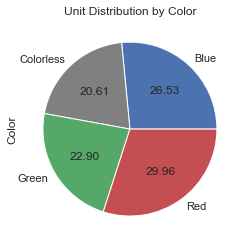

In [68]:
# See the number of characters for each color
sns.set()

colors = heroes.groupby(by="Color").agg(np.size).iloc[:, 6]
colors = colors.rename("Color")
colors.plot.pie(labels=['Blue', 'Colorless', 'Green', 'Red'], 
                colors=['b', 'gray', 'g', 'r'], autopct='%.2f')
plt.title("Unit Distribution by Color")
plt.show()

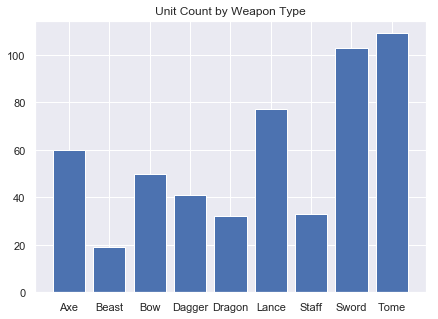

In [69]:
# See the number of characters for each weapon type
sns.set()
plt.figure(figsize=(7, 5))
plt.bar([0, 1, 2, 3, 4, 5, 6, 7, 8], 
        heroes.groupby(by = "Weapon").agg(np.size).iloc[:, 0], align = "center")
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], 
        heroes.groupby(by = "Weapon").agg(np.size).index)
plt.title("Unit Count by Weapon Type")
plt.show()

We see that characters that use tomes are the most abundant in the game (barely beating out those who use swords). However, we should note that there are three different colors associated with tome users, while sword users are all red. Below we will show a distribution of the color of tome users.

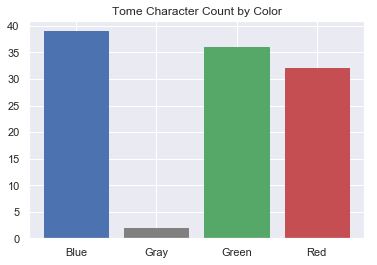

In [72]:
# Tome
tomebar = plt.bar([0, 1, 2, 3], heroes.loc[heroes["Weapon"] == 
            "Tome"].groupby(by = "Color").agg(np.size).iloc[:, 0], align = "center")
tomebar[np.where(heroes.loc[heroes["Weapon"] == 
            "Tome"].groupby(by = "Color").agg(np.size).index.values == "Red")[0][0]].set_color('r')
tomebar[np.where(heroes.loc[heroes["Weapon"] == 
            "Tome"].groupby(by = "Color").agg(np.size).index.values == "Blue")[0][0]].set_color('b')
tomebar[np.where(heroes.loc[heroes["Weapon"] == 
            "Tome"].groupby(by = "Color").agg(np.size).index.values == "Green")[0][0]].set_color('g')
tomebar[np.where(heroes.loc[heroes["Weapon"] == 
            "Tome"].groupby(by = "Color").agg(np.size).index.values == "Gray")[0][0]].set_color('gray')
plt.xticks([0, 1, 2, 3], heroes.loc[heroes["Weapon"] == 
            "Tome"].groupby(by = "Color").agg(np.size).index)
plt.title("Tome Character Count by Color")
plt.show()

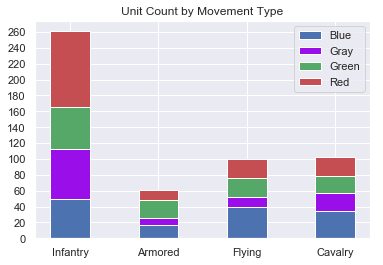

In [74]:
# See the number of characters for each movement type
sns.set()

mov_ty = ["Infantry", "Armored", "Flying", "Cavalry"]
inf = (heroes[heroes["Movement"] == mov_ty[0]].groupby(by = "Color").agg(np.size).iloc[:, 0])
arm = (heroes[heroes["Movement"] == mov_ty[1]].groupby(by = "Color").agg(np.size).iloc[:, 0])
fly = (heroes[heroes["Movement"] == mov_ty[2]].groupby(by = "Color").agg(np.size).iloc[:, 0])
cav = (heroes[heroes["Movement"] == mov_ty[3]].groupby(by = "Color").agg(np.size).iloc[:, 0])
inds = heroes[heroes["Movement"] == mov_ty[0]].groupby(by = "Color").agg(np.size).index
inds

zos = np.array((inf[0], arm[0], fly[0], cav[0]))
ones = np.array((inf[1], arm[1], fly[1], cav[1]))
twos = np.array((inf[2], arm[2], fly[2], cav[2]))
tres = np.array((inf[3], arm[3], fly[3], cav[3]))

ind = np.arange(4)    
width = 0.45      

p1 = plt.bar(ind, zos, width, color = "b")
p2 = plt.bar(ind, ones, width,  bottom=zos, color = "xkcd:violet")
p3 = plt.bar(ind, twos, width,  bottom= zos + ones, color = "g")
p4 = plt.bar(ind, tres, width, bottom = zos + ones + twos, color = "r")

plt.title("Unit Count by Movement Type")
plt.xticks(ind, ("Infantry", "Armored", "Flying", "Cavalry"))
plt.yticks(np.arange(0, np.sum(inf) + 10, 20))
plt.legend((p1[0], p2[0], p3[0], p4[0]), (inds))

plt.show()

#heroes.groupby(by = "Movement Type").agg(np.size).iloc[:, 0].groupby(by = "Color").agg(np.size).iloc[:, 0]

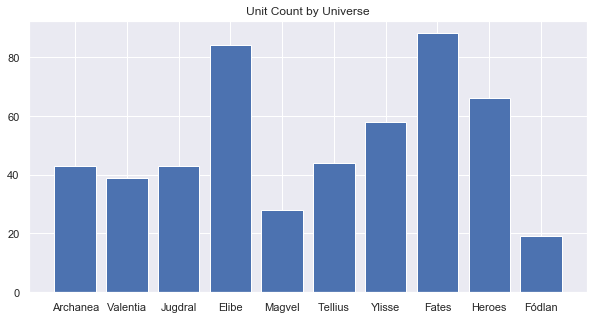

In [76]:
# See the number of characters for each universe
sns.set()

Universes = []

Archanea = len(heroes.loc[heroes["Origin"] == "Fire Emblem: Mystery of the Emblem"]) \
+ len(heroes.loc[heroes["Origin"] == "Fire Emblem: Shadow Dragon and the Blade of Light"]) \
+ len(heroes.loc[heroes["Origin"] == "Fire Emblem: New Mystery of the Emblem"])
Valentia = len(heroes.loc[heroes["Origin"] == "Fire Emblem Echoes"])
Jugdral = len(heroes.loc[heroes["Origin"] == "Fire Emblem: Genealogy of the Holy War"]) \
+ len(heroes.loc[heroes["Origin"] == "Fire Emblem: Thracia 776"])
Elibe = len(heroes.loc[heroes["Origin"] == "Fire Emblem: The Blazing Blade"]) \
+ len(heroes.loc[heroes["Origin"] == "Fire Emblem: The Binding Blade"])
Magvel = len(heroes.loc[heroes["Origin"] == "Fire Emblem: The Sacred Stones"])
Tellius = len(heroes.loc[heroes["Origin"] == "Fire Emblem: Path of Radiance"]) \
+ len(heroes.loc[heroes["Origin"] == "Fire Emblem: Radiant Dawn"])
Ylisse = len(heroes.loc[heroes["Origin"] == "Fire Emblem: Awakening"])
Fates = len(heroes.loc[heroes["Origin"] == "Fire Emblem Fates"])
Heroes = len(heroes.loc[heroes["Origin"] == "Fire Emblem Heroes"])
threeH = len(heroes.loc[heroes["Origin"] == "Fire Emblem: Three Houses"])
     
Universes.append(Archanea)
Universes.append(Valentia)
Universes.append(Jugdral)
Universes.append(Elibe)      
Universes.append(Magvel)
Universes.append(Tellius)
Universes.append(Ylisse)
Universes.append(Fates)
Universes.append(Heroes)
Universes.append(threeH)

plt.figure(figsize=(10, 5))
plt.bar(np.arange(10), Universes, align = "center")
plt.xticks(np.arange(10), ["Archanea", "Valentia", "Jugdral", "Elibe", "Magvel", "Tellius", 
                          "Ylisse", "Fates", "Heroes", "Fódlan"])
plt.title("Unit Count by Universe")
plt.show()

The universes above correspond to the following games:

Archanea: _Fire Emblem: Shadow Dragon_ and _Fire Emblem: Mystery of the Emblem_  
Valentia: _Fire Emblem Gaiden_ / _Fire Emblem Echoes: Shadows of Valentia_  
Jugdral: _Fire Emblem: Geneology of the Holy War_ and _Fire Emblem Thracia 776_  
Elibe: _Fire Emblem: Binding Blade_ and _Fire Emblem: Blazing Sword_ (known as _Fire Emblem_ in the US)  
Magvel: _Fire Emblem: Sacred Stones_  
Tellius: _Fire Emblem: Path of Radiance_ and _Fire Emblem: Radiant Dawn_  
Ylisse: _Fire Emblem: Awakening_  
Fates: _Fire Emblem: Fates_  
Heroes: _Fire Emblem: Heroes_  
Fódlan: _Fire Emblem: Three Houses_  

We can see that certain universes have noticeably higher representation in the game. Fates characters make up about close to 20% of the current total character count. Elibe (Blazing Sword and Binding Blade) and Awakening make up the rest of the top three. It is likely that popularity of the entries is related to character representation.

Interestingly, it appears that Gamepress.gg records spin-off characters as having Fire Emblem Heroes as its origin, such as Legendary Hector and Halloween Mia. We will fix this later on.

Fire Emblem: Three Houses was just recently released in July 2019, so it is likely more characters will be rolled out from that entry soon enough.

## Conclusion

At this point, we have successfully scraped data from a host website in a proper way, extracting important information and processing data into a clean dataframe. We also visualized the data to gain initial insights into what kind of dataset you have made. From here, we can do multiple things with this data, such as create a model for predicting the labeled tier of a unit, or perform exploratory data analysis on a specific set of characters. 